## Download Data

In [ ]:
import pandas as pd
from pathlib import Path

INSdata=pd.read_csv(Path("InsuranceDataset(update).csv"))

## Take a Quick Look at the Data Structure

In [83]:
INSdata.head()

,index,age,sex,home,bmi,children,smoker,drinking
0,0,49,female,Kowloon,32.3,2.0,no,no
1,1,55,female,South NT,29.5,2.0,no,occasional
3,3,19,male,Hong Kong Island,33.2,0.0,no,occasional
4,4,59,male,Hong Kong Island,36.5,1.0,no,frequent
6,6,42,female,Kowloon,40.8,1.0,no,frequent


In [24]:
INSdata.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   age          1338 non-null   int64  
 1   sex          1338 non-null   object 
 2   home         1338 non-null   object 
 3   bmi          1338 non-null   float64
 4   children     1335 non-null   float64
 5   smoker       1338 non-null   object 
 6   drinking     1338 non-null   object 
 7   past claims  1338 non-null   int64  
dtypes: float64(2), int64(2), object(4)
memory usage: 83.8+ KB


In [25]:
INSdata["sex"].value_counts()

male      676
female    662
Name: sex, dtype: int64

In [26]:
INSdata["home"].value_counts()

South NT            364
North NT            325
Hong Kong Island    325
Kowloon             324
Name: home, dtype: int64

In [27]:
INSdata["children"].value_counts()

0.0    573
1.0    324
2.0    239
3.0    156
4.0     25
5.0     18
Name: children, dtype: int64

In [28]:
INSdata["smoker"].value_counts()

no     1064
yes     274
Name: smoker, dtype: int64

In [29]:
INSdata["drinking"].value_counts()

occasional    800
frequent      271
no            267
Name: drinking, dtype: int64

In [30]:
INSdata.describe()

,age,bmi,children,past claims
count,1338.000000,1338.000000,1335.000000,1338.000000
mean,39.281764,29.738341,1.093633,90388.195815
std,14.207480,6.109329,1.205092,84782.257933
min,18.000000,14.800000,0.000000,3374.000000
25%,27.000000,25.400000,0.000000,30353.750000
50%,39.000000,29.500000,1.000000,63390.000000
75%,51.000000,33.600000,2.000000,113611.000000
max,119.000000,52.100000,5.000000,442160.000000


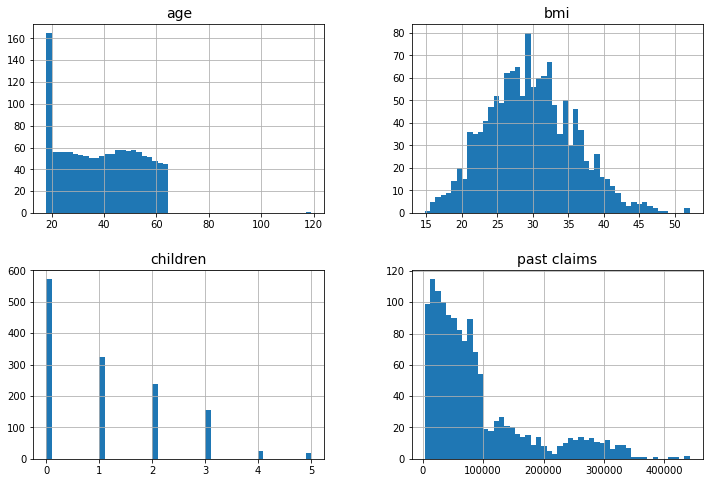

In [31]:
import matplotlib.pyplot as plt

# define the default font sizes
plt.rc('font', size=14)
plt.rc('axes', labelsize=14, titlesize=14)
plt.rc('legend', fontsize=14)
plt.rc('xtick', labelsize=10)
plt.rc('ytick', labelsize=10)

INSdata.hist(bins=50, figsize=(12, 8))
plt.show()

## Create a Test Set

In [14]:
import numpy as np

def shuffle_and_split_data(data, test_ratio):
    shuffled_indices = np.random.permutation(len(data))
    test_set_size = int(len(data) * test_ratio)
    test_indices = shuffled_indices[:test_set_size]
    train_indices = shuffled_indices[test_set_size:]
    return data.iloc[train_indices], data.iloc[test_indices]

In [32]:
train_set, test_set = shuffle_and_split_data(INSdata, 0.2)
len(train_set)

1071

In [17]:
len(test_set)

267

In [18]:
np.random.seed(42)

In [19]:
from zlib import crc32

def is_id_in_test_set(identifier, test_ratio):
    return crc32(np.int64(identifier)) < test_ratio * 2**32

def split_data_with_id_hash(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: is_id_in_test_set(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [33]:
data_with_id = INSdata.reset_index()  # adds an `index` column
train_set, test_set = split_data_with_id_hash(data_with_id, 0.2, "index")

## Looking for Correlations

In [36]:
corr_matrix = INSdata.corr()

In [37]:
corr_matrix["past claims"].sort_values(ascending=False)

past claims    1.000000
age            0.290948
bmi            0.198060
children       0.068155
Name: past claims, dtype: float64

Focus on age and bmi attributes.

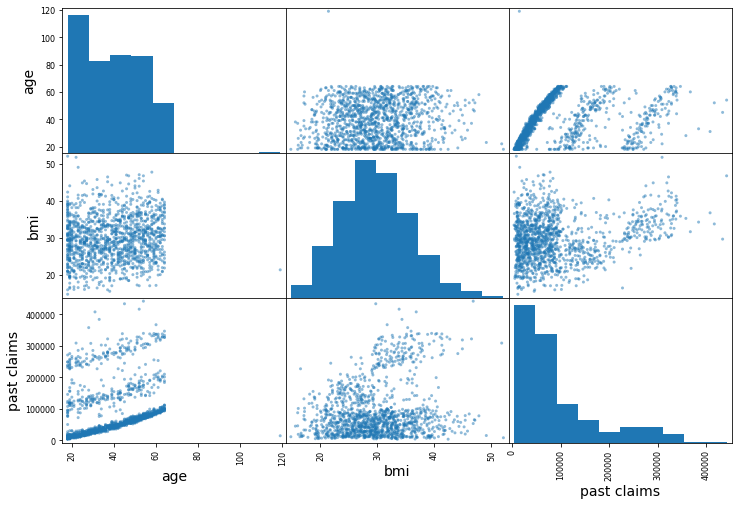

In [40]:
from pandas.plotting import scatter_matrix

attributes = ["age", "bmi","past claims"]
scatter_matrix(INSdata[attributes], figsize=(12, 8))
plt.show()

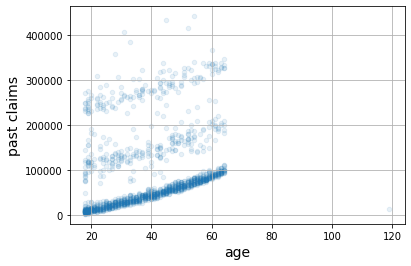

In [41]:
INSdata.plot(kind="scatter", x="age", y="past claims",
             alpha=0.1, grid=True)
plt.show()

Clearly, the most promising attribute to predict past claims is age

##Data Cleaning

In [45]:
INSdata = train_set.drop("past claims", axis=1)
INSdata_labels = train_set["past claims"].copy()

In [46]:
from sklearn.impute import SimpleImputer

imputer = SimpleImputer(strategy="median")

In [53]:
age_num = INSdata.select_dtypes(include=[np.number])

In [55]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
housing_num_std_scaled = std_scaler.fit_transform(age_num)

In [58]:
from sklearn.linear_model import LinearRegression

target_scaler = StandardScaler()
scaled_labels = target_scaler.fit_transform(INSdata_labels.to_frame())

model = LinearRegression()
model.fit(INSdata[["age"]], scaled_labels)
some_new_data = INSdata[["age"]].iloc[:5]  # pretend this is new data

scaled_predictions = model.predict(some_new_data)
predictions = target_scaler.inverse_transform(scaled_predictions)

In [59]:
imputer.fit(age_num)

SimpleImputer(strategy='median')

In [60]:
imputer.statistics_

array([668.5,  39. ,  29.5,   1. ])

In [62]:
age_num.median().values

array([668.5,  39. ,  29.5,   1. ])

In [65]:
X = imputer.transform(age_num)
imputer.feature_names_in_
INSdata_tr = pd.DataFrame(X, columns=age_num.columns,
                          index=age_num.index)

In [67]:
null_rows_idx = INSdata.isnull().any(axis=1)
INSdata.loc[null_rows_idx].head()
INSdata_tr.loc[null_rows_idx].head()

,index,age,bmi,children
464,464.0,61.0,38.4,1.0
1077,1077.0,22.0,34.1,1.0
1317,1317.0,55.0,31.7,1.0


In [68]:
from sklearn.ensemble import IsolationForest

isolation_forest = IsolationForest(random_state=42)
outlier_pred = isolation_forest.fit_predict(X)

In [69]:
outlier_pred

array([-1, -1, -1, ..., -1, -1, -1])

## Transformation Pipelines

In [71]:
from sklearn.pipeline import Pipeline

num_pipeline = Pipeline([
    ("impute", SimpleImputer(strategy="median")),
    ("standardize", StandardScaler()),
])

In [74]:
from sklearn.pipeline import make_pipeline, Pipeline

In [77]:
from sklearn.compose import make_column_selector, make_column_transformer

preprocessing = make_column_transformer(
    (num_pipeline, make_column_selector(dtype_include=np.number))
)

##Train the Model

In [78]:
from sklearn.linear_model import LinearRegression

lin_reg = make_pipeline(preprocessing, LinearRegression())
lin_reg.fit(INSdata, INSdata_labels)

Pipeline(steps=[('columntransformer',
                 ColumnTransformer(transformers=[('pipeline',
                                                  Pipeline(steps=[('impute',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('standardize',
                                                                   StandardScaler())]),
                                                  <sklearn.compose._column_transformer.make_column_selector object at 0x7f9cd2eed0d0>)])),
                ('linearregression', LinearRegression())])

In [79]:
INSdata_predictions = lin_reg.predict(INSdata)
INSdata_predictions[:5].round(-2)

array([121400., 123100.,  68500., 144700., 129800.])

In [81]:
INSdata_labels.iloc[:5].values

array([72433, 79358,  7020, 82368, 48702])

## Evaluate the Model

In [82]:
from sklearn.metrics import mean_squared_error

lin_rmse = mean_squared_error(INSdata_labels, INSdata_predictions,
                              squared=False)
lin_rmse

79828.96596030329

The RMSE of this model is 79828.